# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Step 1: Data exploration

First, we'll load the files and see how data is structured.

In [1]:
import pandas as pd
import numpy as np
import json

% matplotlib inline

import math
from datetime import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


It looks like the offer ids could be shorter and way more informative.

### Profile

In [3]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


Here, it could make sense to just assing a number to each user instead of giving them a long alphanumerical id. Besides, the fact that there are several users aged 118 with no gender or income information is suspicious. Most likely, 118 is the age assigned automatically to those people who chose not to share any information when the signed up. Those rows are good candidates to be dropped later.

Let's visualize the age distribution of the population:

In [4]:
# Define a function to make the plot
def plot_distribution(column, x_label):
    """
    INPUT:
    column - dataframe column to be plotted
       
    Description:
    Plot the value_counts of a specific dataframe column.
    """
    # Get the distribution
    distribution = column.value_counts().sort_index()
    
    # Make the plot
    col_text = 'Value counts per category'  
    plot = pd.DataFrame(distribution.values, columns=[col_text], index=distribution.keys())
    ax = plot.plot.bar(figsize=(20,5), title=(x_label + ' distribution'))
    ax.set(xlabel=x_label, ylabel="Value counts")
    

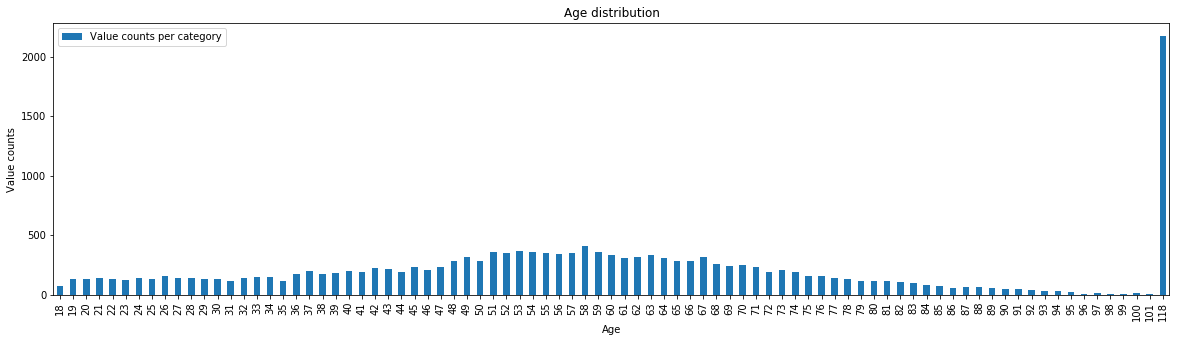

In [5]:
# Visualize the age distribution   
plot_distribution(profile['age'], 'Age')

This seems to confirm our previous guess about the users aged 118. But let's verify it:

In [6]:
metrics.accuracy_score(profile[profile['age'] < 118]['id'].tolist(), profile.dropna()['id'].tolist())

1.0

Now, let's visualize the income distribution:

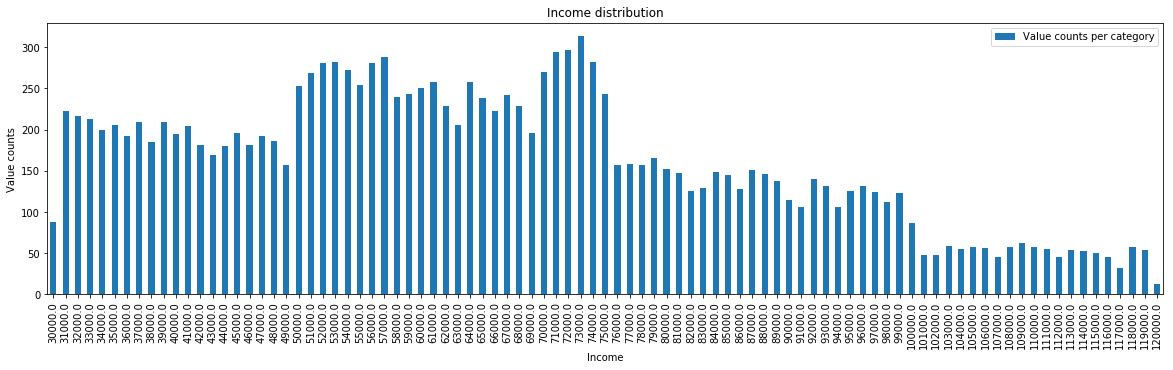

In [7]:
# Visualize the income distribution
plot_distribution(profile['income'], 'Income')

Later, we'll also categorize users into age groups and income groups, for a better handling of the data.

### Transcript

In [8]:
transcript.sort_values(by=['person', 'time']).head(10)

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


Here, we'll also need to modify the user ids. We'll have to split the value column and then modify the offer ids as well.

# Step 2: Data wrangling

Now, let's clean and organize the datasets we've been provided with.

### Portfolio
We'll assign a new id to each offer, containing information about the offer type, its difficulty, duration and reward, as well as the channels used for its distribution. This will help us with data visualization later. 

To that end, we'll create a dict that establishes a one-to-one correspondance between the old and the new ids. But first, we'll sort the rows by offer type.

In [9]:
# Sort rows by offer type and reset indexes
portfolio_df = portfolio.sort_values(by='offer_type').reset_index(drop=True)

# Create an array with the new ids 
new_ids = ['100710-bogo-*ems', 
           '100510-bogo-wems', 
           '050705-bogo-wem*', 
           '050505-bogo-wems',
           '201005-disc-we**',
           '070703-disc-wems',
           '101002-disc-wems',
           '100702-disc-wem*',
           '000400-info-wem*',
           '000300-info-*ems'
          ]

# Create the dictionary
offer_dict = dict(zip(portfolio_df['id'].tolist(), new_ids))

# Define a function to perform the mapping
def map_offer_ids(column, offer_dict=offer_dict):
    """
    INPUT:
    column - dataframe column containing the old ids
    offer_dict - dictionary containing the correspondance between old and new ids
    
    OUTPUT:
    new_column - dataframe column containing the new ids 
    
    Description:
    Replace old ids by new ids according to a dictionary.
    """
    
    new_column = column.apply(lambda x: offer_dict[x] if x in offer_dict else x)
        
    return new_column


In [10]:
# Replace the ids
portfolio_df['id'] = map_offer_ids(portfolio_df['id'])
portfolio_df

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,100710-bogo-*ems,bogo,10
1,"[web, email, mobile, social]",10,5,100510-bogo-wems,bogo,10
2,"[web, email, mobile]",5,7,050705-bogo-wem*,bogo,5
3,"[web, email, mobile, social]",5,5,050505-bogo-wems,bogo,5
4,"[web, email]",20,10,201005-disc-we**,discount,5
5,"[web, email, mobile, social]",7,7,070703-disc-wems,discount,3
6,"[web, email, mobile, social]",10,10,101002-disc-wems,discount,2
7,"[web, email, mobile]",10,7,100702-disc-wem*,discount,2
8,"[web, email, mobile]",0,4,000400-info-wem*,informational,0
9,"[email, mobile, social]",0,3,000300-info-*ems,informational,0


### Profile
We'll drop the rows corresponding to those users who didn't share any information about them. Then, we'll replace each user's id by a number. Finally, we'll group the age and income values into categories.

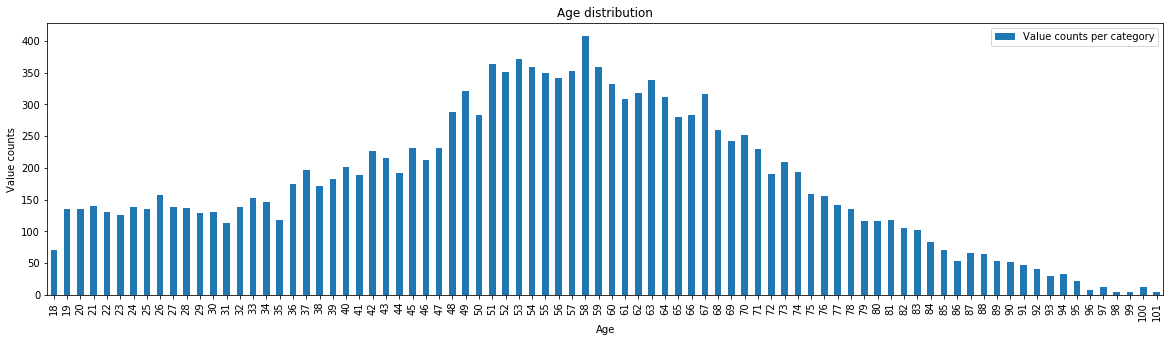

In [11]:
# Drop rows with missing data
profile_dropna = profile.dropna()

# Visualize the new age distribution  
plot_distribution(profile_dropna['age'], 'Age')

In [12]:
# Define function to replace user ids 
def replace_user_ids(df, id_col_name='id'):
    """
    INPUT:
    df - dataframe where the user id column needs to be modified
    id_col_name - name of the column to be modified
    
    OUTPUT:
    new_df - dataframe with the updated user id column 
    
    Description:
    Replace user ids in a dataframe by numbers.
    """
    
    # Sort dataframe by user id
    new_df = df.sort_values(by=id_col_name)
    
    # Get user id column as an array
    old_ids_array = new_df[id_col_name].tolist()
    
    # First element will be assigned the number 1
    current_old_id = old_ids_array[0]
    new_id = 1
    
    # Go over old_ids_array. Every time a new value is found, new_id is increased   
    # Append new_id to new_ids_array
    new_ids_array = []
    for old_id in old_ids_array:
        if old_id != current_old_id:
            new_id += 1
            current_old_id = old_id
        new_ids_array.append(new_id)
    
    # Drop the old id column and add the new one
    new_df = new_df.drop(columns=id_col_name)
    new_df['user_id'] = new_ids_array
    
    return new_df


In [13]:
#Replace user ids by numbers
profile_users = replace_user_ids(profile_dropna)

# Set user_id column as index
profile_users = profile_users.set_index('user_id')
profile_users.head()

,age,became_member_on,gender,income
user_id,,,,
1,33,20170421,M,72000.0
2,40,20180109,O,57000.0
3,59,20160304,F,90000.0
4,24,20161111,F,60000.0
5,26,20170621,F,73000.0


Now, we'll create a function to group up values on a specific column into categories, according to ranges of values.

In [14]:
# Define a function to group up values
def categorize_column(df, col_name, step, start, end):
    """
    INPUT:
    df - dataframe where the user id column needs to be categorized
    col_name - name of the column to be categorized
    step - range of values to be considered for each category
    start - value where the categorization starts
    end - value where the categorization ends
    
    OUTPUT:
    new_df - dataframe with the updated user id column 
    
    Description:
    Replace a column in a dataframe by a categorized version of itself.
    """
    
    # Adapt for large values
    k=1000
    k_str = ''
    if step>=k:
        df[col_name] = df[col_name].apply(lambda x: x/k)
        step = step/k
        start = start/k
        end = end/k
        k_str = 'k'
        
    # Get upper_bound for the ranges. Get first and last category names
    top = step - 1   
    first_cat = str(start-1) + '-  '
    last_cat = '>' + str(end)
    
    # Generate new column
    new_col_name = col_name + '_grp'
    new_col = df[col_name].apply(lambda x: int(x/step)*step)
    new_col = new_col.apply(lambda x: last_cat if x>=end else (first_cat if x<start else str(int(x))+'-'+str(int(x)+top)))
    df[new_col_name] = new_col
    
    # Add k for large values
    df[new_col_name] = df[new_col_name].apply(lambda x: x + k_str)
    
    # Place new column in the same position as the original
    col_list = df.columns.tolist()[:-1]
    col_position = col_list.index(col_name)
    cols_reordered = col_list[:col_position] + [new_col_name] + col_list[col_position+1:]
    new_df = df.copy()
    new_df = new_df[cols_reordered]
    
    return new_df
    
# Categorize age column
profile_age = categorize_column(profile_users, 'age', 10, 30, 80)
profile_age.head()

,age_grp,became_member_on,gender,income
user_id,,,,
1,30-39,20170421,M,72000.0
2,40-49,20180109,O,57000.0
3,50-59,20160304,F,90000.0
4,29-,20161111,F,60000.0
5,29-,20170621,F,73000.0


In [15]:
# Categorize income column
profile_income = categorize_column(profile_age, 'income', 20000, 40000, 100000)
profile_income.head()

,age_grp,became_member_on,gender,income_grp
user_id,,,,
1,30-39,20170421,M,60-79.0k
2,40-49,20180109,O,40-59.0k
3,50-59,20160304,F,80-99.0k
4,29-,20161111,F,60-79.0k
5,29-,20170621,F,60-79.0k


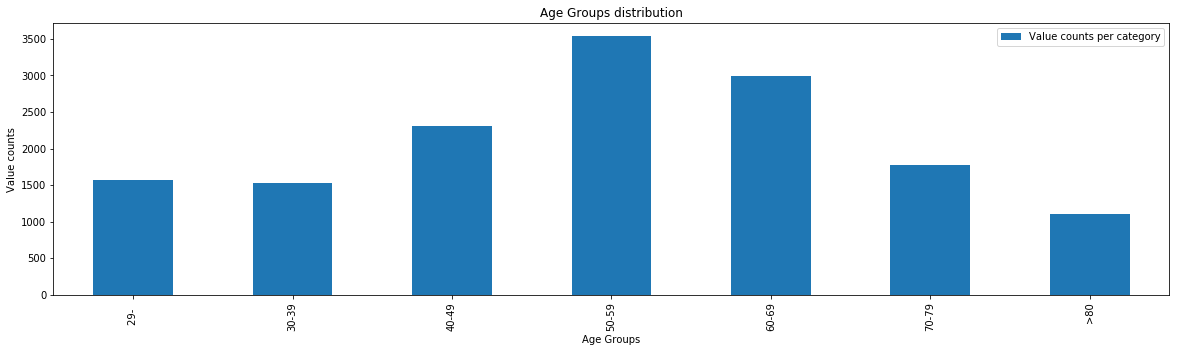

In [16]:
# Visualize new age distribution
plot_distribution(profile_income['age_grp'], 'Age Groups')

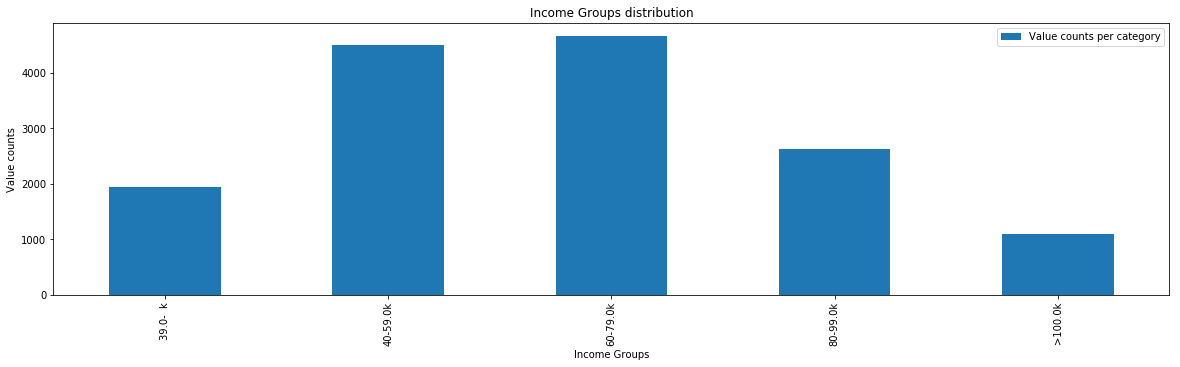

In [17]:
# Visualize new income distribution
plot_distribution(profile_income['income_grp'], 'Income Groups')

Now, we'll categorize the became_member_on column and convert it into the years_member column. To that end, we'll only consider year and month for each date. We'll convert the month into a decimal value between 0 and 1 that will be added to the year. Then, we'll subtract each date in the dataset from the current date. 

Please, notice we'll divide the months by 12+1, so that June is rounded down: 6/(12+1) < 0.5

#### Disclaimer:
These datasets were generated in 2018, so we need to remove the offset. We'll subtract min-1, so the most recent users appear as if they joined 1 year ago. 

In [18]:
# Convert current date into a year plus a decimal
current_month = datetime.now().month/(12+1)
current_date = datetime.now().year + current_month

# Convert each date into a year plus a decimal
div = 10000
new_col = profile_income['became_member_on'].apply(lambda x: int(x/div) + ((round(x/div, 2)-int(x/div))*100)/(12+1))

# Subtract each date from the current date
new_col = new_col.apply(lambda x: round(current_date - x))

# Subtract offset to correct the dates
new_col = new_col.apply(lambda x: x - (new_col.min()-1))

# Categorize and remove the original column
profile_df = profile_income.copy()
profile_df['years_member'] = new_col
profile_df = profile_df.drop(columns=['became_member_on'])

In [19]:
profile_df.head()

,age_grp,gender,income_grp,years_member
user_id,,,,
1,30-39,M,60-79.0k,2
2,40-49,O,40-59.0k,1
3,50-59,F,80-99.0k,3
4,29-,F,60-79.0k,2
5,29-,F,60-79.0k,2


### Transcript
On this dataframe, we need to modify the user ids, split the value column and then map the offer ids.

In [20]:
# Replace user ids by numbers
transcript_df = replace_user_ids(transcript, 'person')    

# Split value column
def split_value_column(df=transcript_df):
    """
    INPUT:
    df - dataframe where the value column needs to be split
    
    OUTPUT:
    new_df - dataframe with the value column split into two 
    
    Description:
    Split the value column of the given dataframe into two new columns: offer_id and transaction.
    """
    
    # Go over the column and get the value from each dict
    # Append strings to one array and floats to another one
    offer_id_column = []
    transaction_column = []
    for item in df['value']:
        value = list(item.values())[0]
        if isinstance(value, str):
            offer_id_column.append(value)
            transaction_column.append(0)
        else:
            offer_id_column.append('')
            transaction_column.append(value)           
            
    # Add both arrays as columns and drop the original
    df['offer_id'] = offer_id_column
    df['transaction'] = transaction_column
    new_df = df.drop(columns='value')
    
    return new_df

transcript_df = split_value_column()

# Map offer ids
transcript_df['offer_id'] = map_offer_ids(transcript_df['offer_id'])


In [21]:
transcript_df.head()

,event,time,user_id,offer_id,transaction
302205,transaction,696,1,,18.41
168412,transaction,414,1,,8.57
300930,transaction,690,1,,28.16
55972,offer received,168,1,000300-info-*ems,0.00
153401,offer received,408,1,050505-bogo-wems,0.00


# Step 3: Data processing

In this section, we'll use portfolio_df, profile_df and transcript_df to generate a new dataframe that condenses all the useful information we need in order to start drawing conclusions.

First, we need a function that takes all the information generated by one user on transcript_df and returns it in an organized manner. For instance, by returning a dict for the offers the user interacted with, how they did it and when. It'll also return the amount of money spent by this user since they signed up.

In [22]:
# Define the function
def get_user_stats(user_id, df=transcript_df, profile_df=profile_df):
    """
    INPUT:
    user_id - user whose interactions need to be analyzed
    df - dataframe containing interactions from all users
    profile_df - dataframe containing information from all users
    
    OUTPUT:
    viewed_dict - dict containing the offers viewed by the user, with timestamps 
    completed_dict - dict containing the offers completed by the user, with timestamps 
    yearly_expenses - amount spent by the user per year since they signed up
    
    Description:
    Get the offers a specific user viewed, the ones they completed, both with timestamps.
    Also get the amount spent per year by that user.
    """    
    
    # Get all the user interactions
    subset = df[df['user_id'] == user_id].sort_values(by='time').sort_index()
    
    # Make the dict of viewed offers 
    view_df = subset[subset['event'] == 'offer viewed']
    viewed_dict = dict(zip(view_df['offer_id'].tolist(), view_df['time'].tolist()))
    
    # Make the dict of completed offers
    comp_df = subset[subset['event'] == 'offer completed']
    completed_dict = dict(zip(comp_df['offer_id'].tolist(), comp_df['time'].tolist()))
      
    # Calculate the amount spent per year by this user (rounded to the tens)    
    total_transactions = df[df['user_id'] == user_id]['transaction'].sum() 
    years_member = profile_df.loc[[1]]['years_member'].tolist()[0]
    yearly_expenses = round(float(total_transactions/years_member)/10)*10
  
    return yearly_expenses, viewed_dict, completed_dict

# Test the function
get_user_stats(1)

(60,
 {'000300-info-*ems': 192,
  '000400-info-wem*': 372,
  '050505-bogo-wems': 456,
  '101002-disc-wems': 540},
 {'050505-bogo-wems': 414, '101002-disc-wems': 528, '100702-disc-wem*': 576})

Now, we need a function to evaluate whether a specific offer was completed willingly or maybe the user just completed it without even noticing. So the following function does that and returns an array containing information about the interactions of a specific user with all the offers in the portfolio, as well as the amount of money they spent per year. These will be considered the user's labels.

In [23]:
# Define the function
def get_user_labels(user_id, portfolio_df=portfolio_df):
    """
    INPUT:
    user_id - user whose row will be generated
    portfolio_df - dataframe containing information about all the offers
    
    OUTPUT:
    user_row - array containing the user's interaction with each of the offers,
            as well as their yearly expenses
    
    Description:
    Get the interaction of a specific user with each one of the offers, as well
    as the amount of money they spent per year.
    """    
    
    # Get user stats and extract offer ids
    yearly_expenses, viewed_dict, completed_dict  = get_user_stats(user_id)
    completed_offers = list(completed_dict.keys())
    viewed_offers = list(viewed_dict.keys()) 
        
    # Assign a 'number of points' to each of the four possible interactions
    willingly_completed = 10000
    false_positive = 100
    ignored = 1
    no_info = 0
      
    # Get offer portfolio
    offer_list = portfolio_df['id'].tolist()
        
    # For an offer to be considered as completed, it must've been viewed BEFORE,
    # otherwise it's a false positive
    interaction_array = []
    for offer in offer_list:
        if offer in completed_offers:
            if offer in viewed_offers:
                elapsed_time = completed_dict[offer] - viewed_dict[offer]
                if elapsed_time >=0:
                    interaction_array.append(willingly_completed)    
                else:
                    interaction_array.append(false_positive)  
            else:
                interaction_array.append(false_positive)
            
        elif (offer in viewed_offers) & (offer not in completed_offers):
            interaction_array.append(ignored)
        
        else:
            interaction_array.append(no_info)

    # Create user_row
    user_labels = [yearly_expenses] + interaction_array
    
                          
    return user_labels

# Test the function
get_user_labels(1)

[60, 0, 0, 0, 100, 0, 0, 100, 100, 1, 1]

Finally, we need a function to go over the whole user list and generate a matrix, where each row represents one user. Each row will contain both the features and labels for that user.

In [24]:
# Define the function
def extend_profile_df(profile_df=profile_df, portfolio_df=portfolio_df):
    """
    INPUT:
    profile_df - dataframe containing information from all users
    portfolio_df - dataframe containing information about all the offers
    
    OUTPUT:
    profile_matrix_df - dataframe containing features and labels for each user
    
    Description:
    Generate a matrix where each row contains the features and labels of one user.
    """     
    
    # Get all user and offer ids
    users_list = profile_df.index.tolist()
    offer_list = portfolio_df['id'].tolist()
    
    # Make a matrix with one row per user, with their features and labels
    profile_matrix = []
    for user in users_list:
        user_features = profile_df.loc[[user]].values.flatten().tolist()
        user_labels = get_user_labels(user)
        profile_matrix.append(user_features + user_labels)
        
        if user%3000 == 0:
            print(user, "users processed")
    
    # Create a dataframe out of the matrix
    col_names = profile_df.columns.tolist() + ['yearly_expenses'] + offer_list
    profile_matrix_df = pd.DataFrame(data=profile_matrix, index=users_list, columns=col_names)
    
    # Drop years_member, as that information is contained in yearly_expenses
    profile_matrix_df = profile_matrix_df.drop(columns=['years_member'])
    
    return profile_matrix_df

In [25]:
# Generate the matrix and display it
profile_matrix = extend_profile_df()
profile_matrix.head()

3000 users processed
6000 users processed
9000 users processed
12000 users processed


,age_grp,gender,income_grp,yearly_expenses,100710-bogo-*ems,100510-bogo-wems,050705-bogo-wem*,050505-bogo-wems,201005-disc-we**,070703-disc-wems,101002-disc-wems,100702-disc-wem*,000400-info-wem*,000300-info-*ems
1,30-39,M,60-79.0k,60,0,0,0,100,0,0,100,100,1,1
2,40-49,O,40-59.0k,0,0,0,0,1,0,0,0,0,0,0
3,50-59,F,80-99.0k,40,0,0,10000,0,10000,10000,0,0,1,1
4,29-,F,60-79.0k,100,0,10000,0,0,0,0,10000,0,0,1
5,29-,F,60-79.0k,80,0,0,10000,10000,0,10000,0,0,0,1


The two informative offers were never completed. Those were probably just ads, instead of actual offers. Therefore, we'll drop those colums:

Let's visualize how the yearly expenses are distributed. As it's a newly created column, we didn't have the chance to take a look at it before.

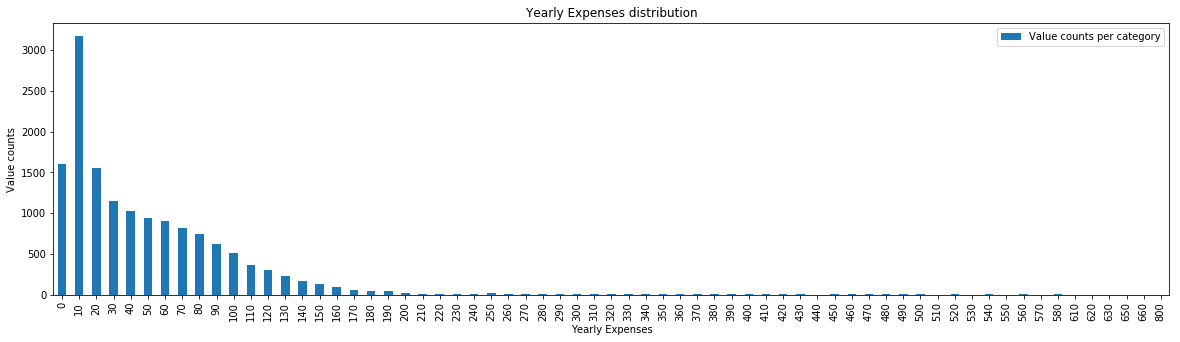

In [26]:
# Visualize the yearly expenses distribution
plot_distribution(profile_matrix['yearly_expenses'], 'Yearly Expenses')


We're going to categorize this column as well:

In [27]:
# Categorize yearly_expenses
profile_matrix_df = categorize_column(profile_matrix, 'yearly_expenses', 50, 50, 100)

# Drop informative offers 
profile_matrix_df = profile_matrix_df.drop(columns=['000400-info-wem*', '000300-info-*ems'])

# Display result
profile_matrix_df.head()

,age_grp,gender,income_grp,yearly_expenses_grp,100710-bogo-*ems,100510-bogo-wems,050705-bogo-wem*,050505-bogo-wems,201005-disc-we**,070703-disc-wems,101002-disc-wems,100702-disc-wem*
1,30-39,M,60-79.0k,50-99,0,0,0,100,0,0,100,100
2,40-49,O,40-59.0k,49-,0,0,0,1,0,0,0,0
3,50-59,F,80-99.0k,49-,0,0,10000,0,10000,10000,0,0
4,29-,F,60-79.0k,>100,0,10000,0,0,0,0,10000,0
5,29-,F,60-79.0k,50-99,0,0,10000,10000,0,10000,0,0


# Step 4: Data analysis

Firstly, it would be interesting to get a general idea on how successful each offer was. We can do that by just adding up each offer's column. Given the 'point system' we used to codify the user-offer interactions in get_user_labels, this will provide us with some useful information.

We're going to define a function that does that and also allows us to compare how well each offer performed with each demographic groups:

In [29]:
# Define a function to display offer stats
def display_offer_stats(split_col=None, df=profile_matrix_df, portfolio_df=portfolio_df):
    """
    INPUT:
    split_col - column we'll use to split the values and compare them
    df - dataframe containing features and labels for each user
    portfolio_df - dataframe containing information about all the offers
        
    Description:
    Make a plot representing how successful each offer was, splitting the
    values according to one column, if it corresponds.
    """    
    
    # Get offer column names
    offer_list = portfolio_df['id'].tolist()
    offer_cols_start = df.columns.tolist().index(offer_list[0])
    offer_column_names = df.columns.tolist()[offer_cols_start:]
    
    if (split_col is None):
        # Get success counts for each offer and normalize
        success_counts = df[offer_column_names].sum()
        total = success_counts.sum()
        norm_values = [100*x/total for x in success_counts]
        
        # Assign data to plot
        data = norm_values
        
    else:
        # Repeat for every possible value of split_col
        filters = df[split_col].value_counts().sort_index().keys()
        data_matrix = []
        for value in filters:
            success_counts = df[df[split_col] == value][offer_column_names].sum()
            total = success_counts.sum()
            norm_values = [100*x/total for x in success_counts]
            data_matrix.append(norm_values)
        
        data = dict(zip(filters, data_matrix))
    
    # Make a plot
    plot = pd.DataFrame(data, index=offer_column_names)
    ax = plot.plot.bar(figsize=(20,5), title=('Compared success of the different offers'))
    ax.set(xlabel='Offers', ylabel="Percentage of success (%)")
    ax.legend(bbox_to_anchor=(1.0, 1.0))


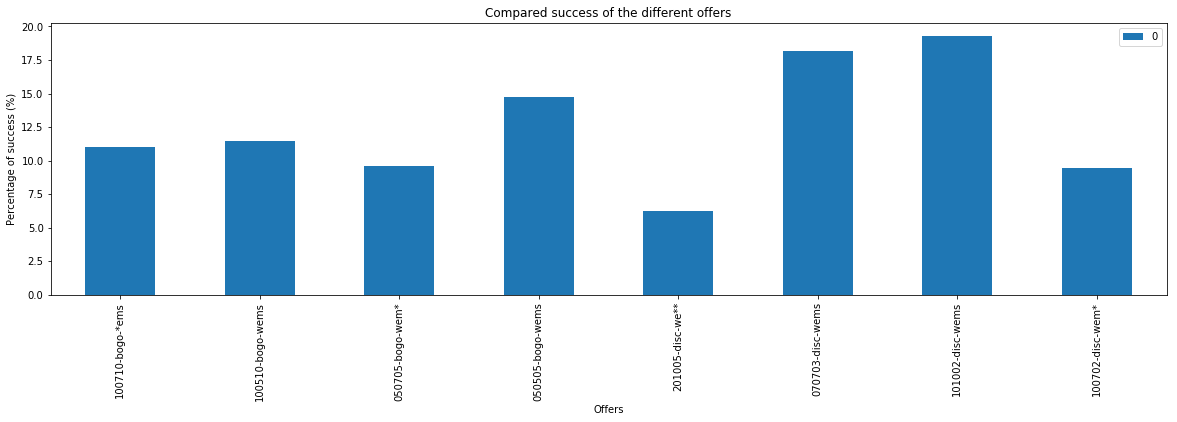

In [30]:
# See offer stats
display_offer_stats()

We can see that, in general terms, 101002-disc-wems, 070703-disc-wems and 050505-bogo-wems are the preferred offers. While 201005-disc-we** seems to be the least favourite.

Let's compare gender groups:

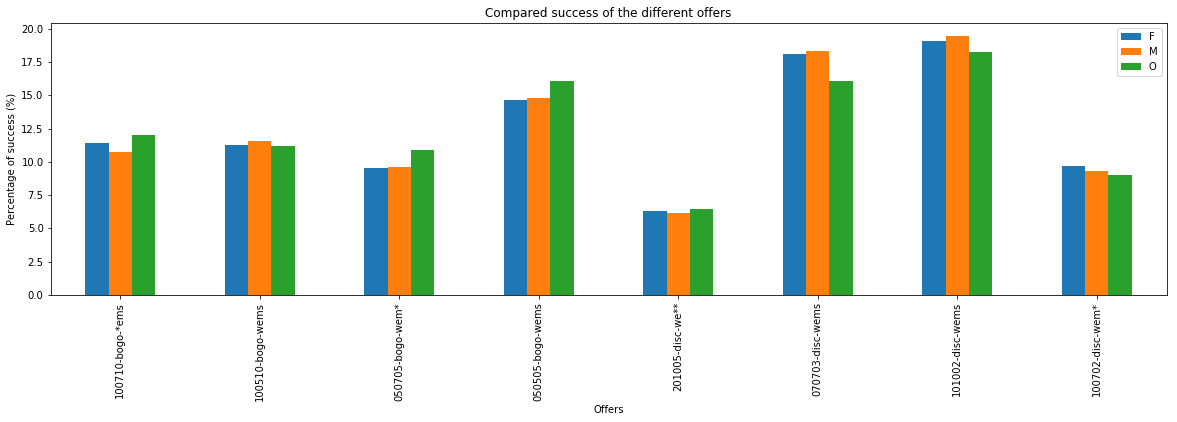

In [31]:
display_offer_stats('gender')

Here, we can observe that people who identify as 'other' seem to like 070703-disc-wems and 050505-bogo-wems similarly.

Let's compare income groups:

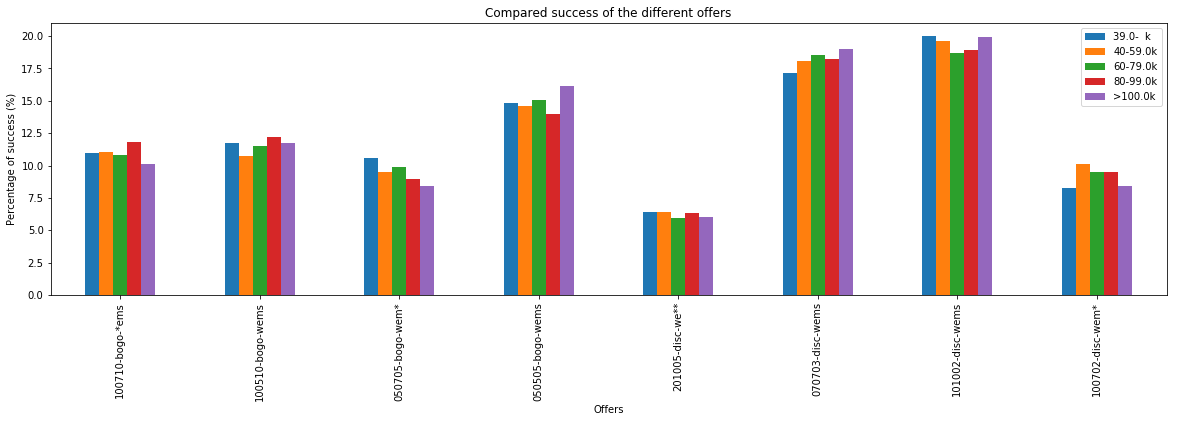

In [32]:
display_offer_stats('income_grp')

No important differences.

Let's compare age groups:

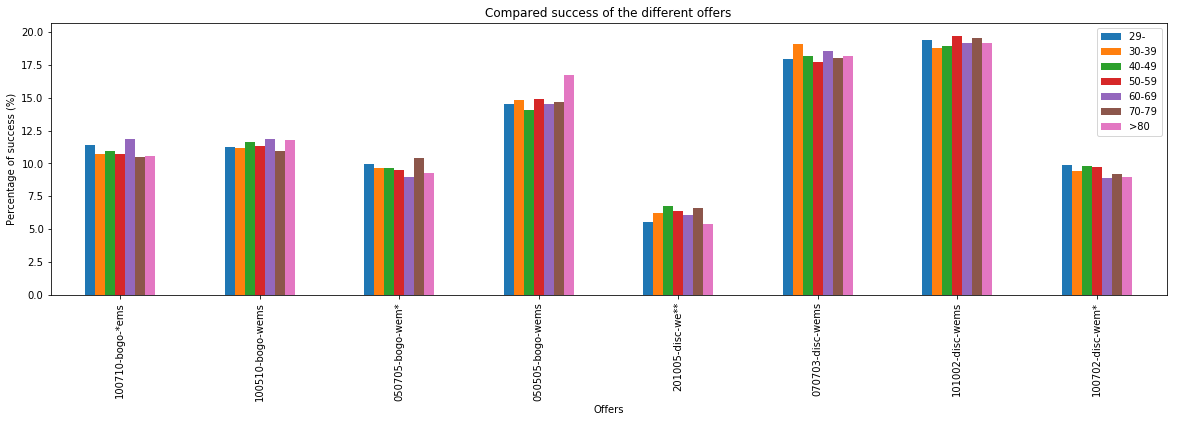

In [33]:
display_offer_stats('age_grp')

No big differences. 

Let's see how the offers preferences relate to the yearly expenses:

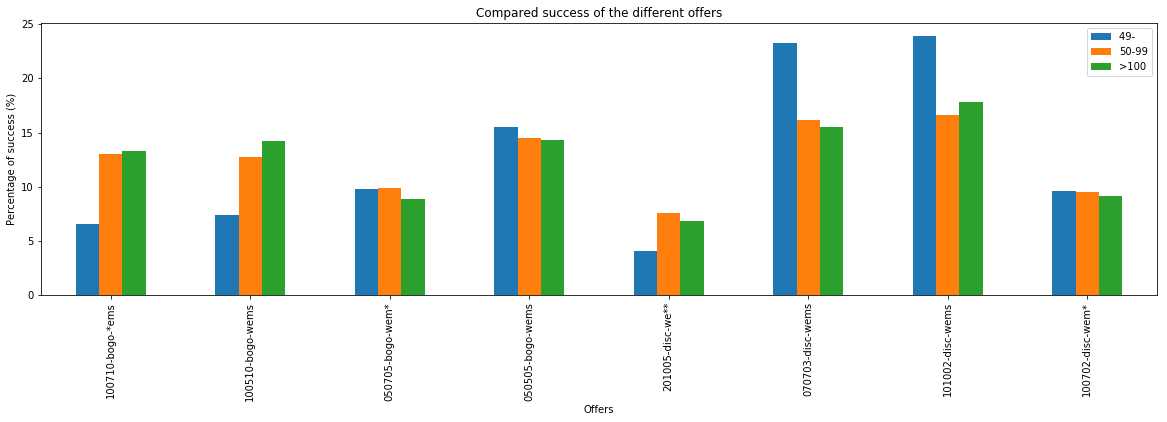

In [34]:
display_offer_stats('yearly_expenses_grp')

Those who spend less than $50 a year have an ever stronger preference than the average for 101002-disc-wems and 070703-disc-wems.

Now, let's try plotting these graphs after filtering the subset by gender:

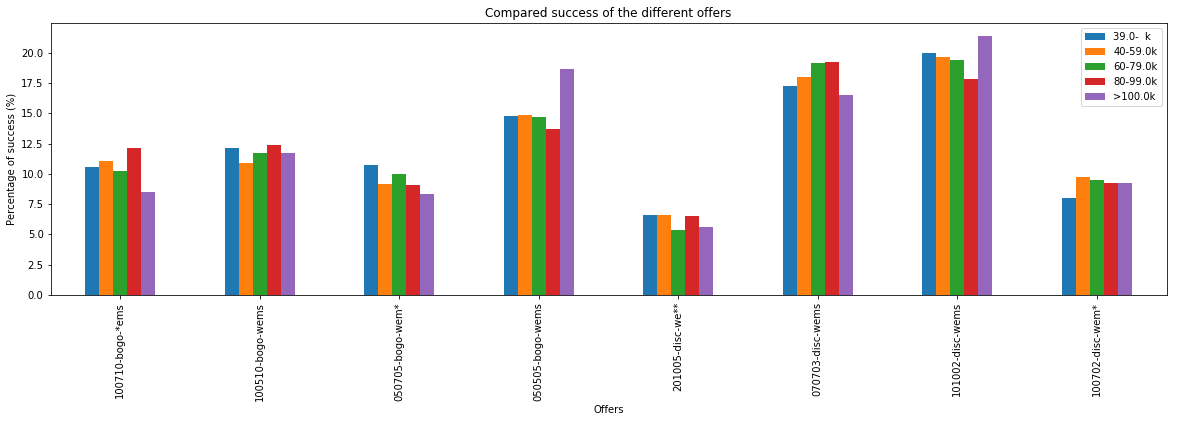

In [93]:
# Filter by gender and compare income groups
subset = profile_matrix_df[profile_matrix_df['gender'] == 'M']
display_offer_stats('income_grp', subset)

Men who earn over 100k prefer 050505-bogo-wems over 070703-disc-wems.

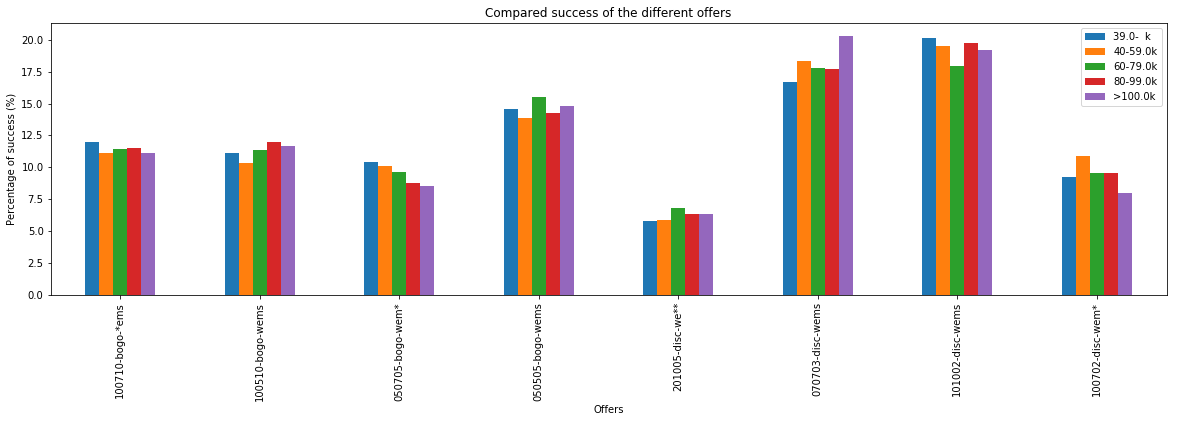

In [94]:
# Filter by gender and compare income groups
subset = profile_matrix_df[profile_matrix_df['gender'] == 'F']
display_offer_stats('income_grp', subset)

Women who earn more than 100k prefer 070703-disc-wems over 101002-disc-wems.

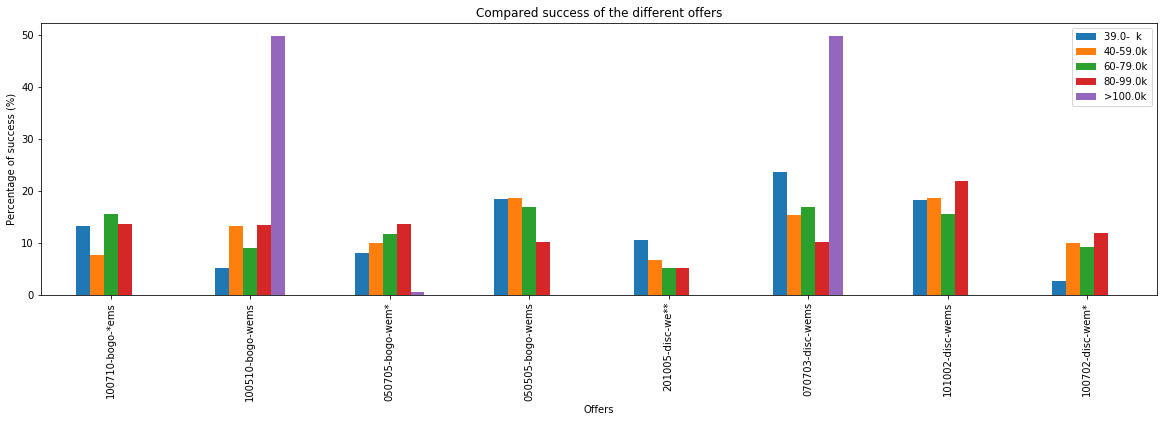

In [95]:
# Filter by gender and compare income groups
subset = profile_matrix_df[profile_matrix_df['gender'] == 'O']
display_offer_stats('income_grp', subset)

Interesting enough, people who identify as 'other' and earn more than 100k have a very strong preference for 100510-bogo-wems and 070703-disc-wems. However, that tremendous difference is suspicious in statistical terms. Maybe the amount of people in that category is too small. Let's check:

In [96]:
# Check amount of people who indentify as 'other' and earn more than 100k
profile_matrix_df[profile_matrix_df['gender'] == 'O']['income_grp'].value_counts()

40-59.0k    70
60-79.0k    61
80-99.0k    51
39.0-  k    28
>100.0k      2
Name: income_grp, dtype: int64

Indeed, that seems to be the case. So we won't take this observation into account.

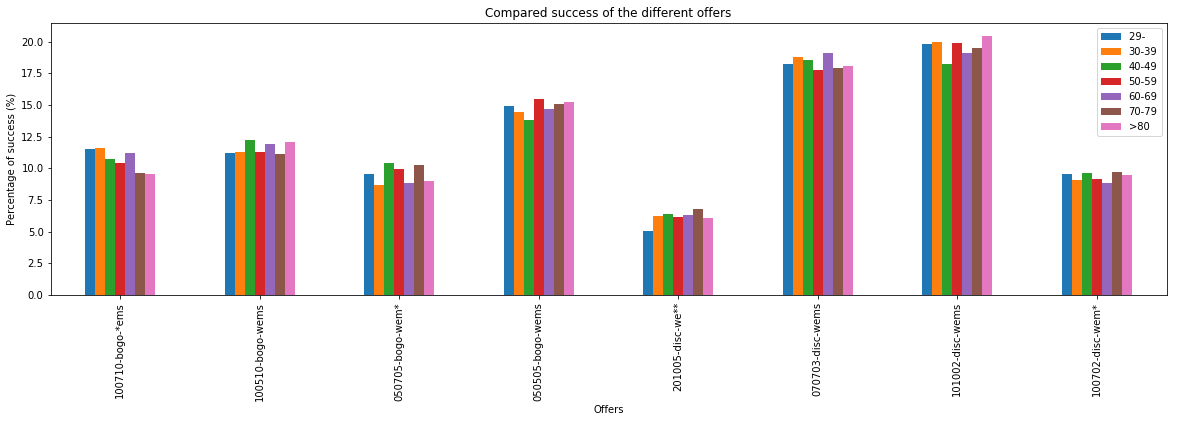

In [97]:
# Filter by gender and compare age groups
subset = profile_matrix_df[profile_matrix_df['gender'] == 'M']
display_offer_stats('age_grp', subset)

Similar to comparing age groups without filtering by gender

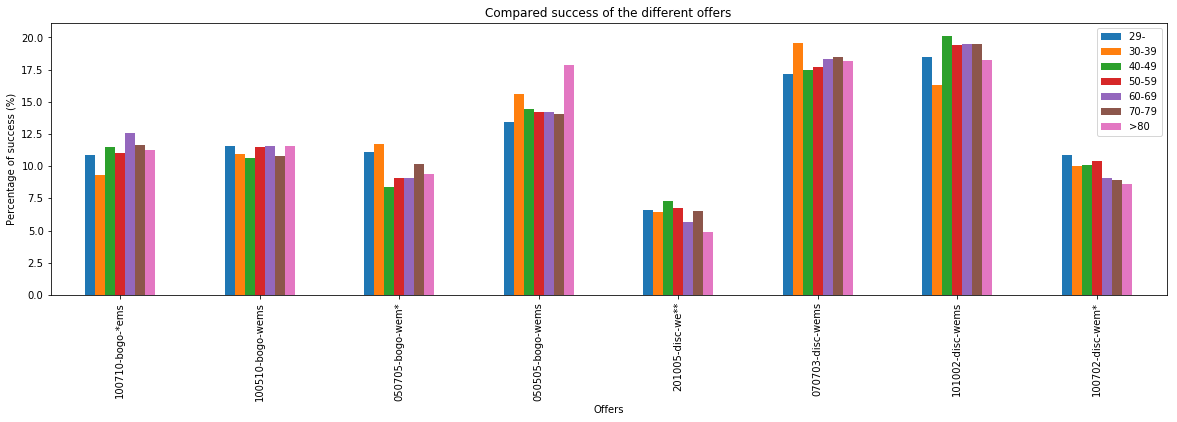

In [98]:
# Filter by gender and compare age groups
subset = profile_matrix_df[profile_matrix_df['gender'] == 'F']
display_offer_stats('age_grp', subset)

Women in the age group 30-39 prefer 070703-disc-wems the most. Women over 80 don't have a strong preference among 101002-disc-wems, 070703-disc-wems and 050505-bogo-wems.

Now, it would also be interesting to see the point distribution on the user axis. That way, we can see if some specific demographic group tends to one behavior more. To that end, we'll define a function that adds up the points horizontally and then plots a bar graph.

In [109]:
def display_user_stats(x_axis, df=profile_matrix_df):
    """
    INPUT:
    x_axis - column the x-axis values will be taken from
    df - dataframe containing features and labels for each user
        
    Description:
    Make a plot to compare how receptive to offers different
    demographic groups are.
    """    
    
    # Make a copy of the dataframe and get points per user
    new_df = df.copy()
    new_df['user_points'] = new_df.sum(axis=1)
    
    # Get x-axis values
    x_axis_values = df[x_axis].value_counts().sort_index().keys().tolist() 
       
    # Create a matrix that contains the data to be displayed
    data_matrix = []
    for value in x_axis_values:
        subset = new_df[new_df[x_axis] == value]
        
        recep = subset[subset['user_points'] >= 10000].shape[0]
        non_recep = subset[subset['user_points'] < 100].shape[0]
        half_recep = subset.shape[0] - (non_recep + recep)
        total = subset.shape[0]
        
        data_matrix.append([100*recep/total, 100*half_recep/total, 100*non_recep/total])
    
    data_matrix_T = np.array(data_matrix).transpose()
    data = dict(zip(['receptive', 'half receptive', 'non receptive'], data_matrix_T)) 
            
    # Make a plot
    plot = pd.DataFrame(data, index=x_axis_values)
    ax = plot.plot.bar(figsize=(20,5), stacked=True, title=('Compared behavior of different demographic groups'))
    ax.set(xlabel='Demographic groups', ylabel="Proportion of members (%)")
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    


Let's compare genders:

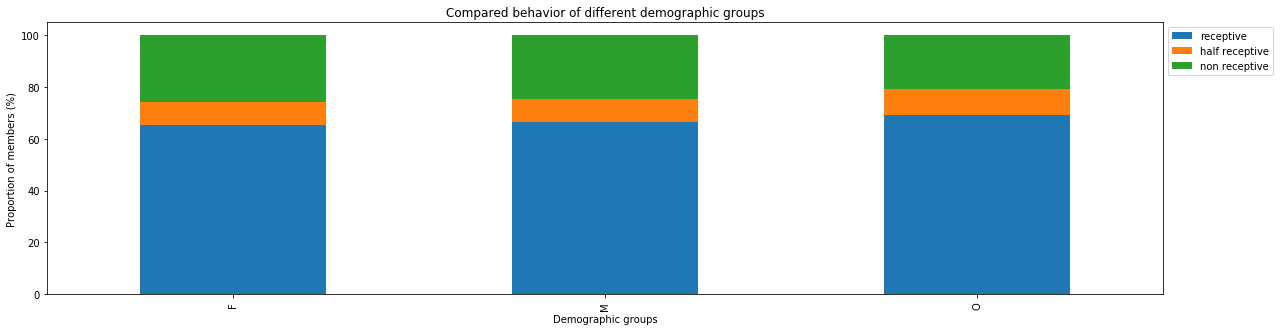

In [110]:
display_user_stats('gender')

All the three categories seem to present a very similar distribution: around 65-70% of users completed at least one offer, around 10% did only false positives and 20-25% ignored the offers they received. 

Let's compare age groups:

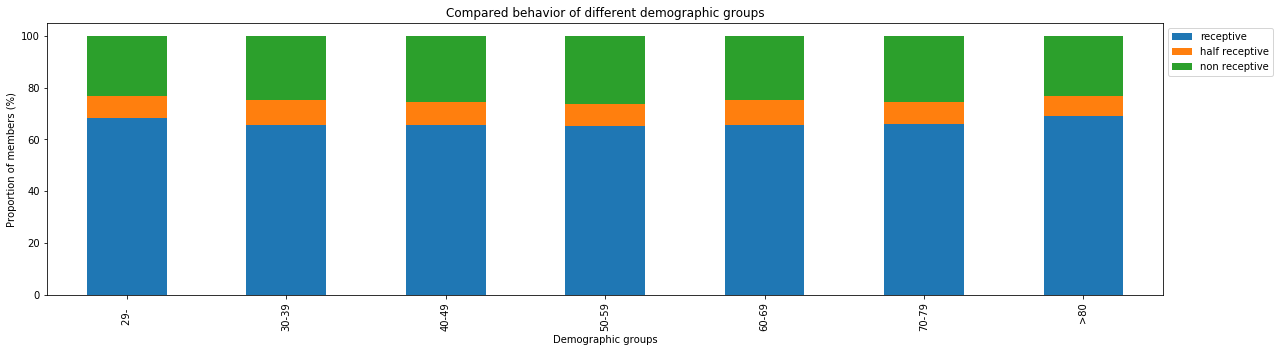

In [111]:
display_user_stats('age_grp')

Again, all groups seem to be very similar. 

Let's compare income groups:

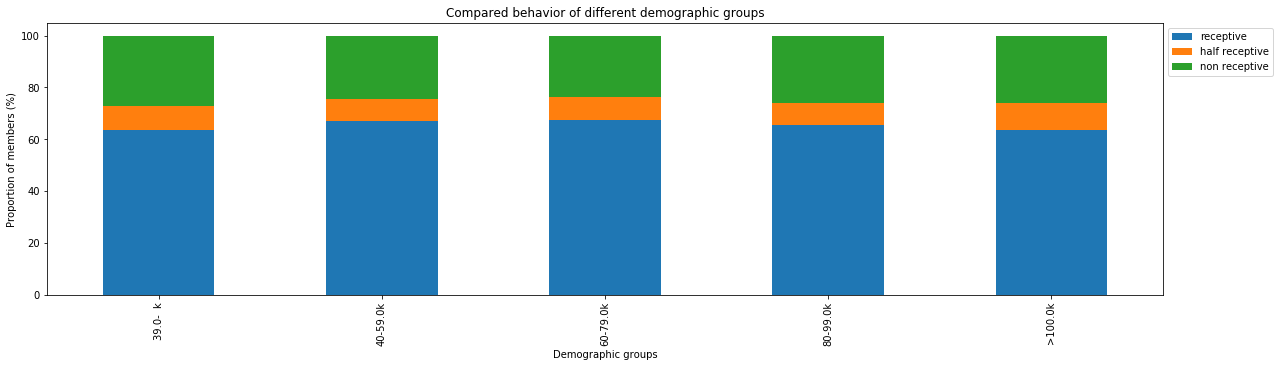

In [112]:
display_user_stats('income_grp')

Also similar. There seems to be a slightly higher receptiveness in the central groups. But the difference is minimal.

Let's compare yearly expenses:

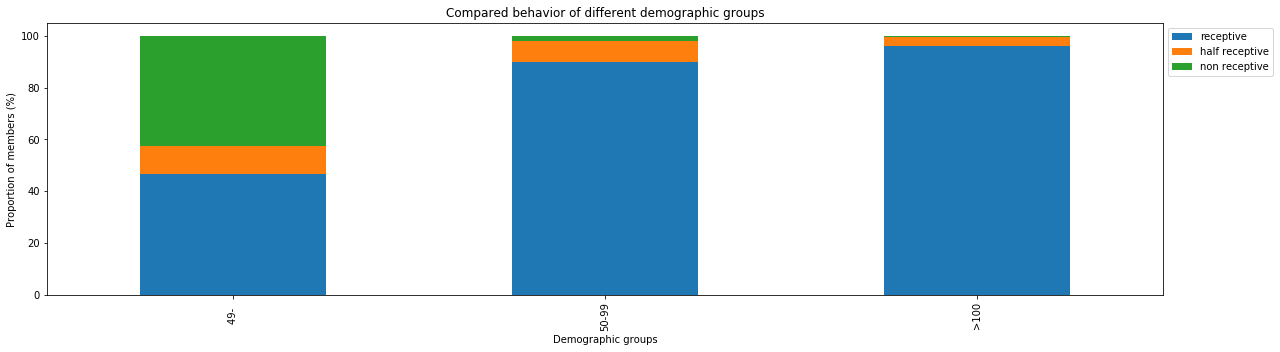

In [113]:
display_user_stats('yearly_expenses_grp')

Here, we can indeed see noticeable differences: people who spend $50 or more per year are way more receptive to offers.